Coin is tossed 10 times. If 6 or fewer heads, win back £1 plus additional £1. 7 or more is a loss

$P(Y=y) = {N \choose y} r^y (1-r)^{N-y}$

$Y$: RV representing number of heads

$y$: number of heads observed

$N$: number of tosses, 10 for this game.

$r$: Unknown, probability of getting a head. 

To find the probability of winning we would like to estimate $r$ based on observing the game. Effectively we want to calculate $p(r|y_N)$, the conditional probability of $r$ given an observed number of heads $y_N$.

$p(r|y_N) = \frac{P(y_N|r)p(r)}{P(y_N)}$

Examine the components individually.

#### Likelihood
$P(y_N|r)$: The probability of observing our data given a particular value of $r$. 

#### Prior
$p(r)$: Any beliefs we have about the distribution of $r$ before observing any data. Our best guess. 

#### Marginal distribution
$P(y_N)$: The likelihood of all data averaged over all parameter values. Usually quite hard to calculate. 

#### Posterior 
$p(r|y_N)$: Distribution of interest. When we get new evidence we update $p(r)$ to take this evidence into account. 


By some mathematical manipulations (equation 3.6 in the book), we find that if we pick a beta distribution for the prior, the posterior is a beta distribution with the following parameters:

$p(r|y_N) = \frac{\Gamma(\alpha + \beta + N)}{\Gamma(\alpha + y_N)\Gamma(\beta + N - y_N)} r^{\alpha + y_N - 1} (1-r)^{\beta + N - y_N - 1}$


## Method
1. Guess a prior
   - It is convenient to pick a prior distribution that will result in a posterior which is the same form as the prior ("Conjugate")
   - The likelihood-prior combination is the one that is conjugate
2. In the case of our coin game, we know our likelihood is binomial, so choose a beta prior
   - Recall that the beta itself has 2 parameters $\alpha$ and $\beta$ that affect the shape. 
3. Observe $y_N$ and update the posterior. 

# 3 scenarios
We investigate 3 scenarios that comprise different priors that describe different beliefs we may have about $r$.

In these scenarios, we choose different beta distributions. $\alpha$ and $\beta$ describe the numbers of heads and tails in $(\alpha + \beta)$ previous tosses. 


## No prior knowledge
We assume that $r$ can take any value between 0 and 1. This comes from a beta distribution with $\alpha=1$ and $\beta=1$.


In [1]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import beta
import numpy as np



In [2]:


from scipy.stats import binom


def draw2(actual_r=0.5):
    # r = p(heads)
    # heads = 1
    return np.random.random() >= (1-actual_r)


a:1, b:1, outcome:True, new_a:2, new_b:1
a:2, b:1, outcome:True, new_a:3, new_b:1
a:3, b:1, outcome:True, new_a:4, new_b:1
a:4, b:1, outcome:True, new_a:5, new_b:1
a:5, b:1, outcome:True, new_a:6, new_b:1
a:6, b:1, outcome:True, new_a:7, new_b:1
a:7, b:1, outcome:True, new_a:8, new_b:1
a:8, b:1, outcome:False, new_a:8, new_b:2
a:8, b:2, outcome:False, new_a:8, new_b:3
a:8, b:3, outcome:True, new_a:9, new_b:3


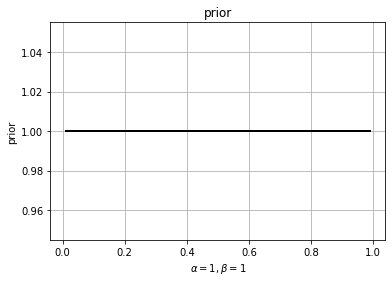

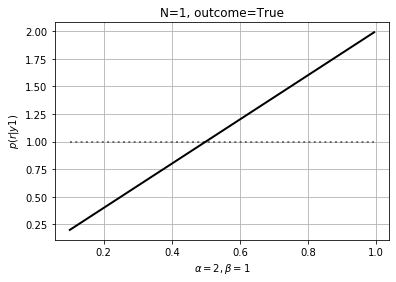

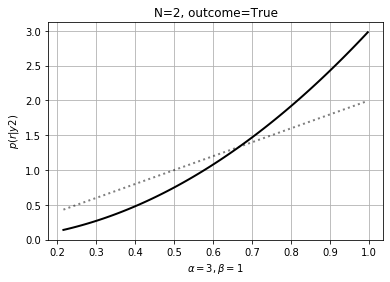

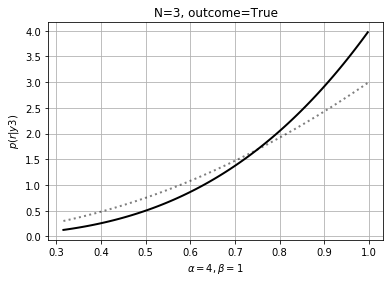

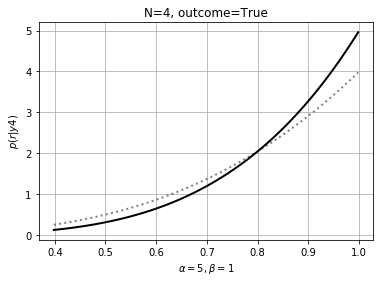

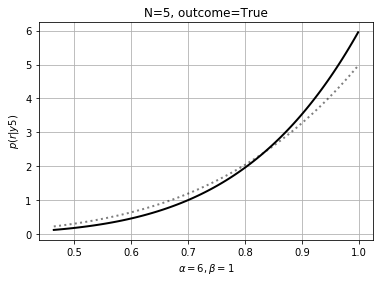

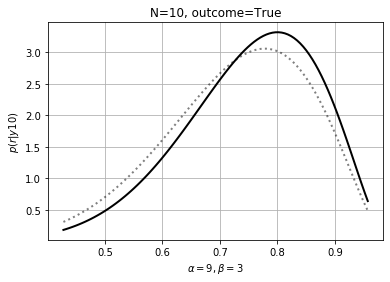

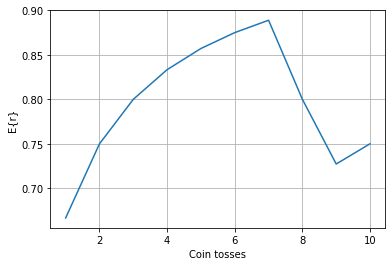

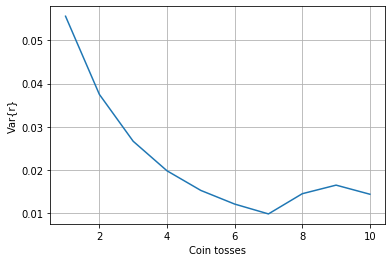

In [3]:
sims1 = [1, 0, 1, 1, 1, 1, 0, 0, 0, 1]
sims2 = [1, 1, 0, 0, 1, 1, 1, 1, 1, 1]

def adjust_posterior(result, a, b, debug=False):
    # result: 1 or 0, outcome of coin toss. 1 = heads
    # a = alpha before the result
    # b = beta before the result
    # returns: a beta distribution with the new parameters
    new_a = a + result
    new_b = b + 1 - result
    if debug:
        print(f'a:{a}, b:{b}, outcome:{result}, new_a:{new_a}, new_b:{new_b}')
    return beta(new_a, new_b)

def plot_posterior(beta_obj, last_beta_obj, title, N):
    a, b = beta_obj.args
    x = np.linspace(beta.ppf(0.01, a, b),
                    beta.ppf(0.99, a, b), 100)

    plt.plot(x, beta_obj.pdf(x), 'k-', lw=2, label=f'beta({a}, {b})')
    if last_beta_obj is not None:
        plt.plot(x, last_beta_obj.pdf(x), 'k:', lw=2, label='previous', alpha=0.5)
    plt.title(title)
    ylabel = 'prior' if N == 0 else f'$p(r|y{N})$'
    plt.ylabel(f"{ylabel}")
    plt.xlabel(fr"$\alpha={a}, \beta={b}$")
    plt.grid()
    
    
def model_posterior(prior, num_tosses, display_step, sims=None, draw_fn=draw2, debug=False, actual_r=0.5):
    # prior: beta distribution encoding the prior
    # num_tosses: total number of tosses to simulate
    # display_step: print every N, except the first N which are all printed
    # if passed: sims should be an array of 0 and 1 representing the simulated tosses. 
    # actual_r: The actual value of r in the distribution
    heads = 0
    np.random.seed(123213122)
    mean_r, var_r = [], []
    if sims is not None:
        num_tosses = len(sims)
    Ns = list(range(0,num_tosses + 1))
    last_beta = None
    for idx, N in enumerate(Ns):
        if N == 0:
            plot_posterior(prior, last_beta, "prior", 0)
            last_beta = prior
            continue
        a, b = last_beta.args
        if sims is not None:
            outcome = sims[idx-1]
        else:
            outcome = draw_fn(actual_r=actual_r)
        beta_N = adjust_posterior(outcome, a, b, debug)
        heads += outcome
        if (num_tosses <= 10 and N <= display_step) or N % display_step == 0:
            plt.figure()
            plot_posterior(beta_N, last_beta, f'N={N}, outcome={outcome}', N)
        last_beta = beta_N
        mean_r.append(beta_N.mean())
        var_r.append(beta_N.var())

    plt.figure()
    plt.plot(Ns[1:], mean_r)
    plt.grid()
    plt.xlabel('Coin tosses')
    plt.ylabel(r"E{r}")
    plt.figure()
    plt.plot(Ns[1:], var_r)
    plt.grid()
    plt.xlabel('Coin tosses')
    plt.ylabel(r"Var{r}")

    
model_posterior(beta(1, 1), 10, 5, draw_fn=draw2, debug=True, actual_r=0.75)
#model_posterior(beta(1, 1), None, 1, sims=sims1)

## Fair coin
Assume that 50 heads and 50 tails have been observed already, leading to a prior with $\alpha=50$ and $\beta=50$

a:50, b:50, outcome:True, new_a:51, new_b:50
a:51, b:50, outcome:True, new_a:52, new_b:50
a:52, b:50, outcome:True, new_a:53, new_b:50
a:53, b:50, outcome:True, new_a:54, new_b:50
a:54, b:50, outcome:True, new_a:55, new_b:50
a:55, b:50, outcome:True, new_a:56, new_b:50
a:56, b:50, outcome:True, new_a:57, new_b:50
a:57, b:50, outcome:False, new_a:57, new_b:51
a:57, b:51, outcome:False, new_a:57, new_b:52
a:57, b:52, outcome:True, new_a:58, new_b:52
a:58, b:52, outcome:False, new_a:58, new_b:53
a:58, b:53, outcome:True, new_a:59, new_b:53
a:59, b:53, outcome:False, new_a:59, new_b:54
a:59, b:54, outcome:False, new_a:59, new_b:55
a:59, b:55, outcome:True, new_a:60, new_b:55
a:60, b:55, outcome:False, new_a:60, new_b:56
a:60, b:56, outcome:True, new_a:61, new_b:56
a:61, b:56, outcome:True, new_a:62, new_b:56
a:62, b:56, outcome:False, new_a:62, new_b:57
a:62, b:57, outcome:True, new_a:63, new_b:57
a:63, b:57, outcome:True, new_a:64, new_b:57
a:64, b:57, outcome:True, new_a:65, new_b:57
a:6

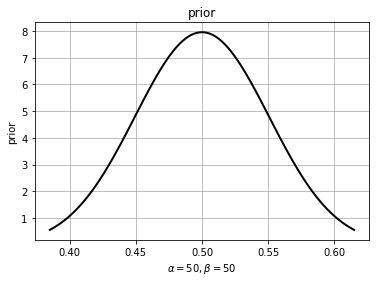

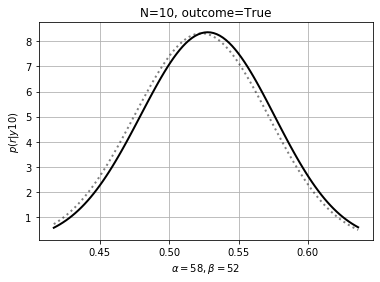

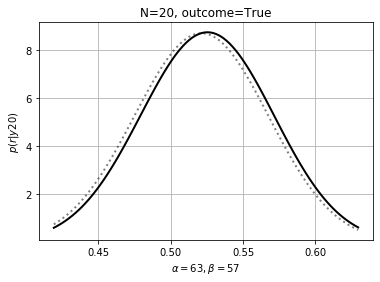

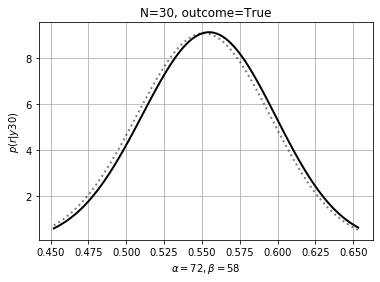

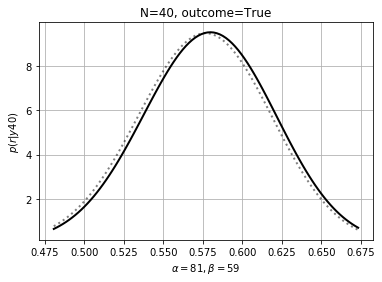

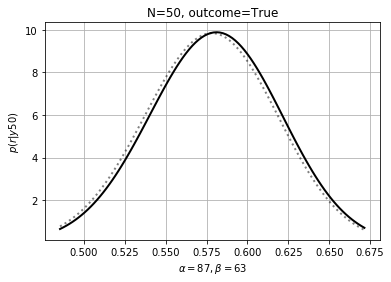

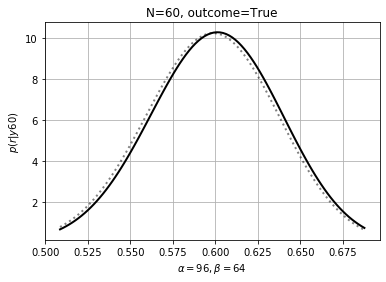

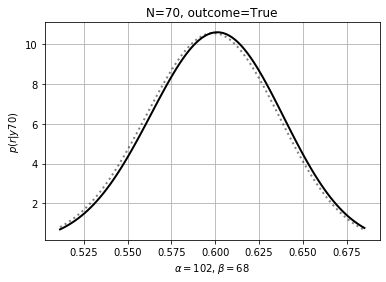

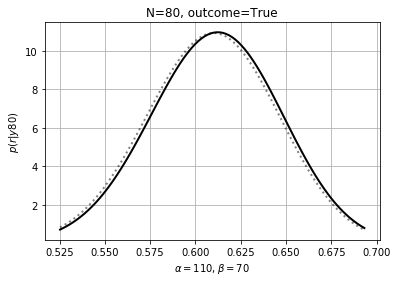

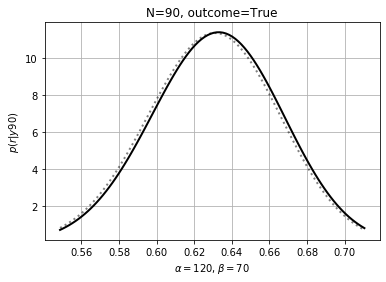

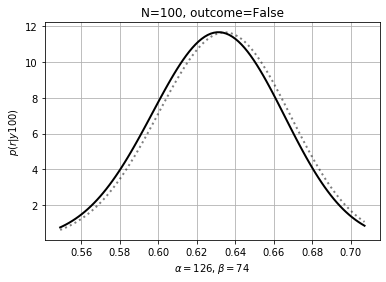

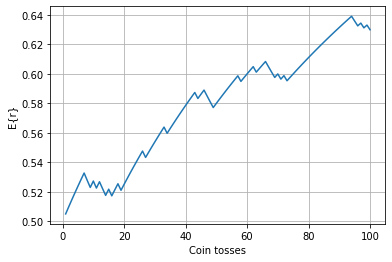

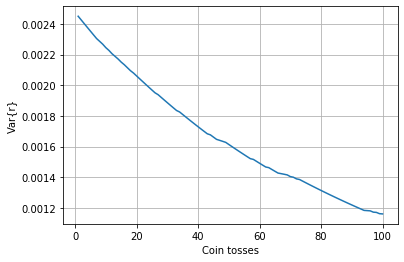

In [4]:
model_posterior(beta(50, 50), 100, 10, draw_fn=draw2, debug=True, actual_r=0.75)
#model_posterior(beta(50, 50), None, 1, sims1+sims2)

## Biased coin

Beta with parameters $\alpha=5$, $\beta=1$

a:5, b:1, outcome:True, new_a:6, new_b:1
a:6, b:1, outcome:True, new_a:7, new_b:1
a:7, b:1, outcome:True, new_a:8, new_b:1
a:8, b:1, outcome:True, new_a:9, new_b:1
a:9, b:1, outcome:True, new_a:10, new_b:1
a:10, b:1, outcome:True, new_a:11, new_b:1
a:11, b:1, outcome:True, new_a:12, new_b:1
a:12, b:1, outcome:False, new_a:12, new_b:2
a:12, b:2, outcome:False, new_a:12, new_b:3
a:12, b:3, outcome:True, new_a:13, new_b:3
a:13, b:3, outcome:False, new_a:13, new_b:4
a:13, b:4, outcome:True, new_a:14, new_b:4
a:14, b:4, outcome:False, new_a:14, new_b:5
a:14, b:5, outcome:False, new_a:14, new_b:6
a:14, b:6, outcome:True, new_a:15, new_b:6
a:15, b:6, outcome:False, new_a:15, new_b:7
a:15, b:7, outcome:True, new_a:16, new_b:7
a:16, b:7, outcome:True, new_a:17, new_b:7
a:17, b:7, outcome:False, new_a:17, new_b:8
a:17, b:8, outcome:True, new_a:18, new_b:8
a:18, b:8, outcome:True, new_a:19, new_b:8
a:19, b:8, outcome:True, new_a:20, new_b:8
a:20, b:8, outcome:True, new_a:21, new_b:8
a:21, b:8, ou

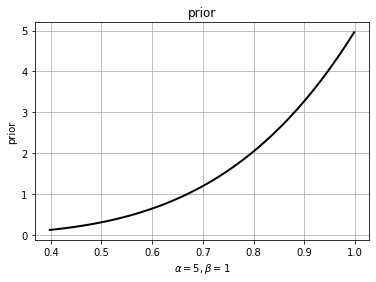

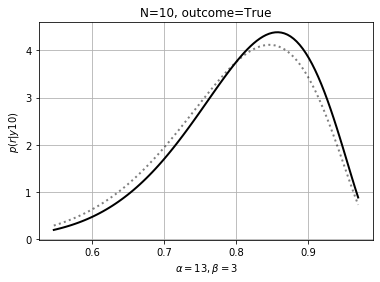

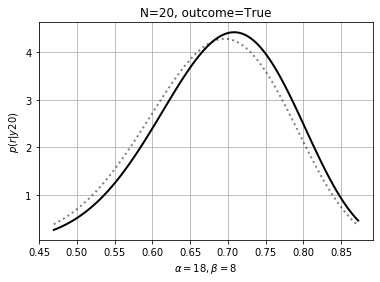

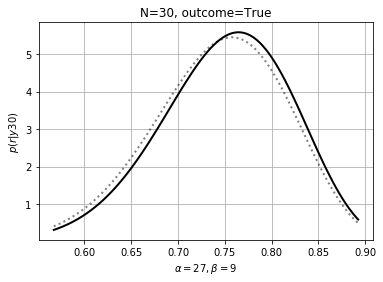

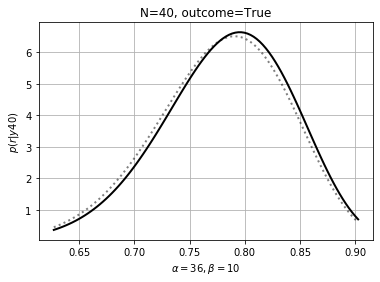

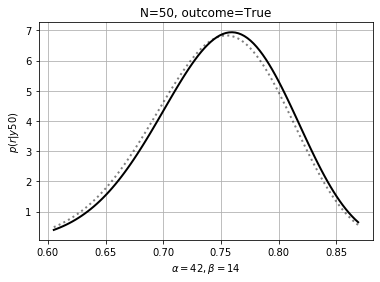

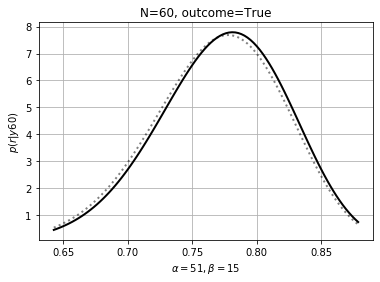

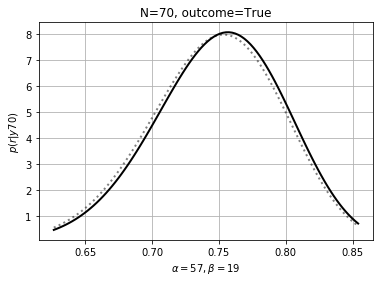

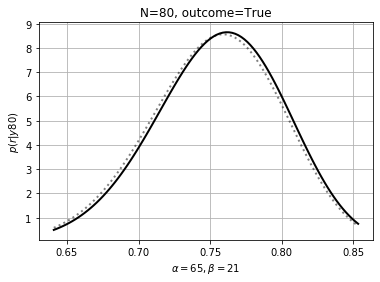

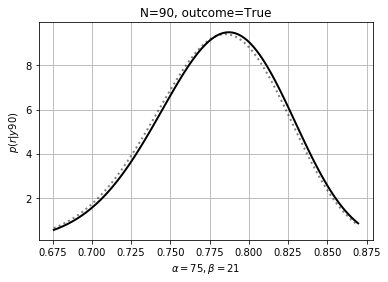

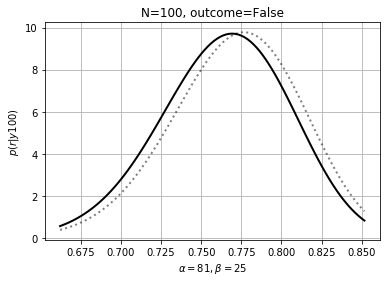

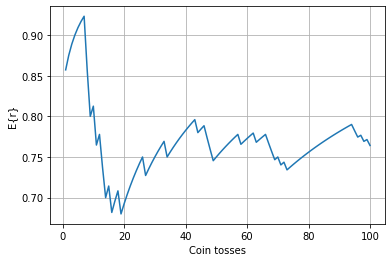

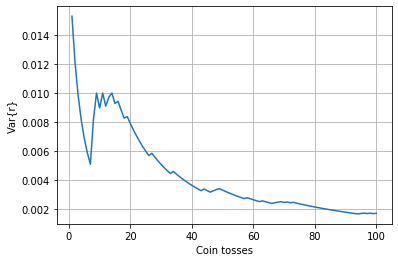

In [5]:

model_posterior(beta(5, 1), 100, 10, draw_fn=draw2, debug=True, actual_r=0.75)
#model_posterior(beta(5, 1), None, 1, sims1+sims2)

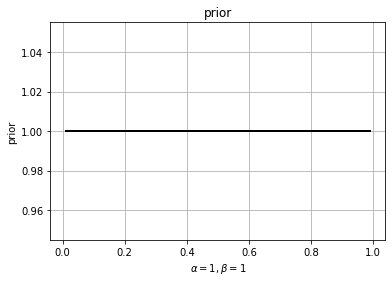

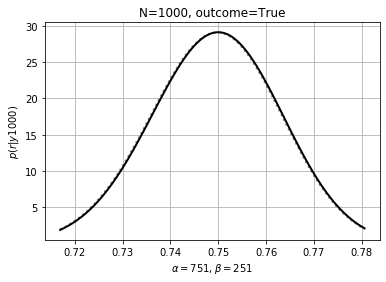

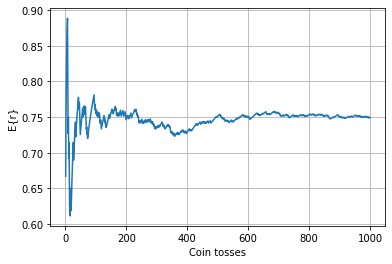

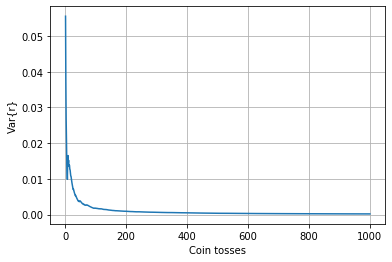

In [6]:
model_posterior(beta(1, 1), 1000, 1000, draw_fn=draw2, actual_r=0.75)

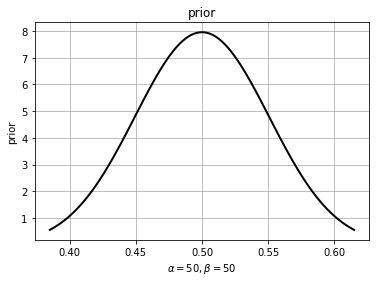

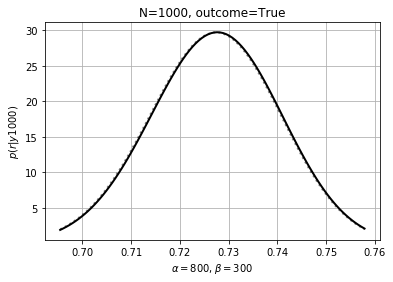

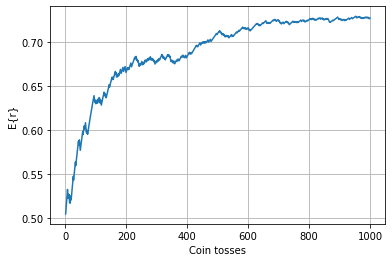

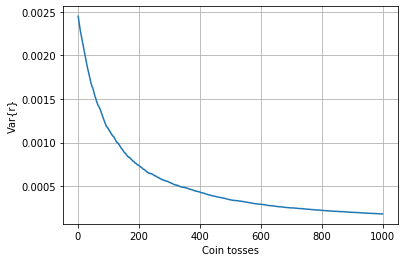

In [7]:
model_posterior(beta(50, 50), 1000, 1000, draw_fn=draw2, actual_r=0.75)

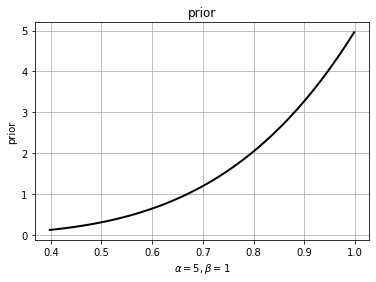

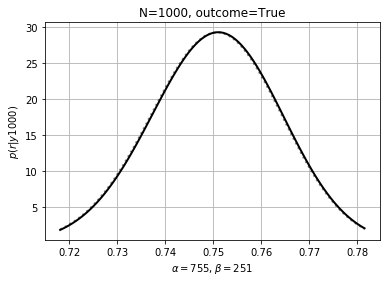

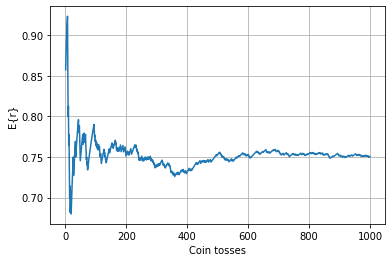

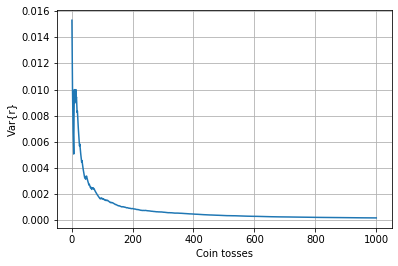

In [8]:
model_posterior(beta(5, 1), 1000, 1000, draw_fn=draw2, actual_r=0.75)

Note that in the book, the actual r used to generate the data for 1000 tosses - which we can't see - is 0.75. This is why all the posterior graphs (after 1000 draws) in the book have a peak  around 07-something. But the posterior of scenario 2 has a peak at a lower value of r than the others because of the strong prior belief. 

When I first wrote the code assuming that it was a fair coin, all my scenarios had peaks at 0.5, which makes sense. 

# Marginal Likelihoods

$p(y_N) = \int_{r=0}^{r=1} p(r, y_N) dr$

$p(y_N|\alpha, \beta) = \int_{r=0}^{r=1} p(y_N|r) p(r|\alpha, \beta) dr$ - marginal likelihood

The marginal likelihood says how likely the data is given particular values of $\alpha$ and $\beta$.

$p(y_N|\alpha, \beta) = \int_{r=0}^{r=1} p(y_N|r) p(r|\alpha, \beta) dr$

$p(y_N|\alpha, \beta) = \int_{r=0}^{r=1} {N \choose y_N} r^{y_N} (1-r)^{N-y_N} \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} r^{\alpha-1} (1-r)^{\beta-1} dr$

Extract all the constants to the outside of the integral

$p(y_N|\alpha, \beta) = {N \choose y_N} \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} \int_{r=0}^{r=1}  r^{y_N} (1-r)^{N-{y_N}} r^{\alpha-1} (1-r)^{\beta-1} dr$

Group terms

$p(y_N|\alpha, \beta) = {N \choose y_N} \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} \int_{r=0}^{r=1}  r^{y_N + \alpha - 1} (1-r)^{N - y_{N} + \beta-1} dr$

The integral term is a beta distribution without the normalising constant. Because we know that the integral over all possible values of r (0 to 1) must be 1, the integral of the unnormalised beta must be the reciprocal of the normalising constant.

$p(y_N|\alpha, \beta) = {N \choose y_N} \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} \frac{\Gamma(y_N + \alpha)\Gamma(N - y_N + \beta)}{\Gamma(N + \alpha + \beta)}$

We can brute force calculate the values of $\alpha$ and $\beta$ that would maximise the value of $p(y_N|\alpha, \beta)$

First we check the marginal likelihoods for our 3 cases



In [9]:
import scipy.special

g = scipy.special.gamma
c = scipy.special.comb

def marginal_likelihood(N, yn, alpha, beta):
    return (
        c(N, yn) * g(alpha+beta) * g(alpha+yn) * g(beta+N-yn) /
        (g(alpha) * g(beta) * g(alpha + beta + N))
    )

### No prior knowledge

In [10]:
print(marginal_likelihood(20, 14, 1, 1))

0.047619047619047616


### Fair coin

In [11]:
print(marginal_likelihood(20, 14, 50, 50))

nan


/home/mog/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
/home/mog/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/home/mog/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


What happened there? Recall the gamma function is like a factorial: $x! = \Gamma(x+1)$

Therefore when we have terms like $\Gamma(50)$, this is a very big number.

Turn it into logs and then invert:

$p(y_N|\alpha, \beta) = {N \choose y_N} \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} \frac{\Gamma(y_N + \alpha)\Gamma(N - y_N + \beta)}{\Gamma(N + \alpha + \beta)}$

$ln(p(y_N|\alpha, \beta)) = ln({N \choose y_N}) + ln( \Gamma(\alpha + \beta)) - ln(\Gamma(\alpha)\Gamma(\beta) + ln(\Gamma(y_N + \alpha)) + ln(\Gamma(N - y_N + \beta)) - ln(\Gamma(N + \alpha + \beta))$

In [12]:
def marginal_likelihood2(N, yn, alpha, beta):
    return np.exp(
        np.log(c(N, yn)) + np.log(g(alpha+beta)) + np.log(g(alpha+yn)) + np.log(g(beta+N-yn)) - 
        np.log(g(alpha)) - np.log(g(beta)) - np.log(g(alpha + beta + N))
    )

There is some difference, but not until the 15th decimal place. 

In [13]:
print(marginal_likelihood(20, 14, 1, 1))
print(marginal_likelihood2(20, 14, 1, 1))

0.047619047619047616
0.047619047619047304


In [14]:
print(marginal_likelihood2(20, 14, 50, 50))

0.04414512187267379


In [15]:
print(marginal_likelihood(20, 14, 50, 1))

0.00023095010116424793


/home/mog/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.
/home/mog/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Z contains NaN values. This may result in rendering artifacts.


/home/mog/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


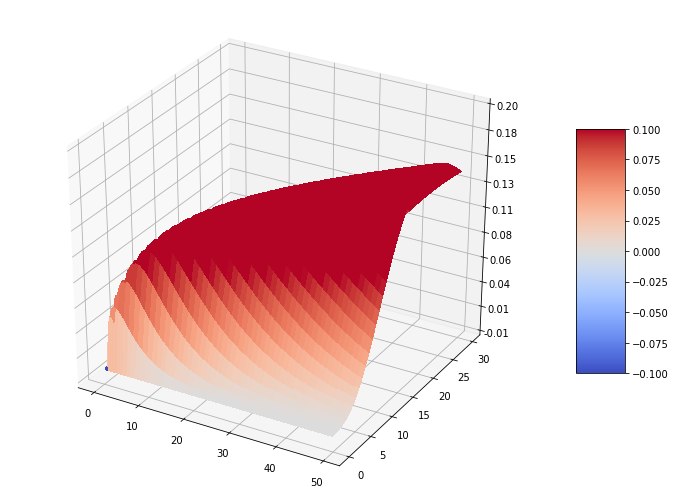

In [16]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure(figsize=(12,9))
ax = fig.gca(projection='3d')

# Make data.
A = np.arange(0, 50, 0.25)
B = np.arange(0, 30, 0.25)
A, B = np.meshgrid(A, B)
Z = marginal_likelihood2(20, 14, A, B)

# Plot the surface.
surf = ax.plot_surface(A, B, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.01, 0.20)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

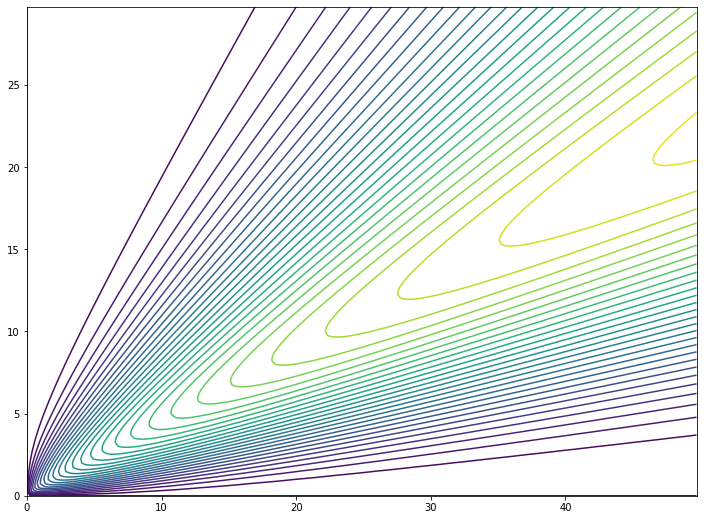

In [17]:
fig, ax = plt.subplots(figsize=(12, 9))
CS = ax.contour(A, B, Z, levels=30)

Can't figure out a way of minimising at integer values, do it by brute force. We know that the maximum must be somewhere where $\alpha = 50$

In [18]:
betas = np.arange(1, 31)

values = marginal_likelihood2(20, 14, 50, betas)

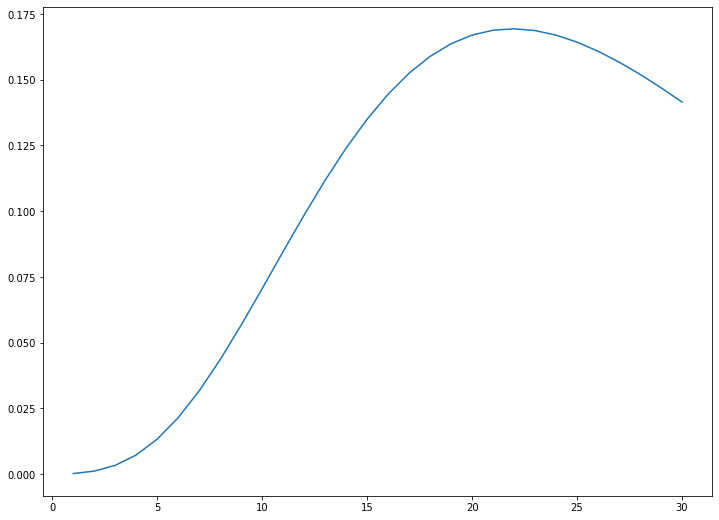

In [19]:
import pandas as pd
pd.Series(values, betas).plot(figsize=(12, 9))